The purpose of this tutorial is to review logistic regression, autoencoders, and the Multilayer Perceptron (MLP)





In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from __future__ import division, print_function
import codecs
import re
import json
import random
import math
import os
import gzip
import cPickle
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pylab
import pandas as pd
from scipy.stats import norm
import nltk
from fuel.datasets import H5PYDataset

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Load fuel dataset (POS windows) DONE
# Load one-hot Word X Document numpy matrix DONE

# train autoencoder, stop when reconstruction performance doesn't improve any more, or after a fixed number of epochs

# CHALLENGE: replace denoising with dropout

# save the parameters of the first part of the network (the encoder)
# use the encoder parameters to build the prediction transformation

# evaluate the performance of the autoencoder features vs. hstacked LSI and W2V features 

In [3]:
# now create the fuel dataset
DATASET_LOCATION = 'datasets/'

# the pos dataset consists of windows around words
POS_DATASET_NAME = 'brown_pos_dataset.hdf5'
POS_DATASET_PATH = os.path.join(DATASET_LOCATION, POS_DATASET_NAME)

CORPUS_INDICES = 'brown_pos_dataset.indices'
WORD_BY_DOC_MATRIX = "brown.word-by-doc.binary.npy"

# Indexes for mapping words <--> ints
with open(os.path.join(DATASET_LOCATION, CORPUS_INDICES)) as indices_file:
    corpus_indices = cPickle.load(indices_file)
    
# Word X Doc binary matrix
word_df = np.load(os.path.join(DATASET_LOCATION, WORD_BY_DOC_MATRIX))


train_X, train_y = H5PYDataset(
    POS_DATASET_PATH, which_sets=('train',),
    sources=['instances', 'targets'], load_in_memory=True).data_sources

dev_X, dev_y = H5PYDataset(
    POS_DATASET_PATH, which_sets=('dev',),
    sources=['instances', 'targets'], load_in_memory=True).data_sources

test_X, test_y = H5PYDataset(
    POS_DATASET_PATH, which_sets=('test',),
    sources=['instances', 'targets'], load_in_memory=True).data_sources

In [4]:
word_df[word_df.nonzero()].mean()

1.0

In [5]:
# let's persist our word tf matrix and see how big it is -- with shape = (9769, 15667) its 292Mb
# WORD_TF="brown.word-tf.npy"
# with open(os.path.join(DATASET_LOCATION, WORD_TF), "wb") as outfile:
#     np.save(outfile, brown_word_tf)

In [6]:
# create a one-layer autoencoder to encode word windows into 100-dim vectors

In [7]:
def create_hstacked_vectors(index_path, seqs, cutoff=None):
    # load the index, map the seqs (word indices) through the index, hstack, then cast the results to np.array
    index = np.load(index_path)
    
    if cutoff is None:
        cutoff = len(seqs)
    
    working_index = np.load(index_path)
    return np.array([np.hstack([index[idx] for idx in seq]) for seq in seqs[:cutoff]])

In [8]:
# load a portion of a fuel dataset

def load_fuel_dataset(filename, which_sets=None):
#     TODO: if which_sets is not None return all sets

    X, y = H5PYDataset(
        filename, which_sets=which_sets,
        sources=['instances', 'targets'], load_in_memory=True).data_sources
    
    # make sure y is 0-dimensional
    y = y.ravel()
    
    #train_set, valid_set, test_set format: tuple(input, target)
    #input is an numpy.ndarray of 2 dimensions (a matrix)
    #where rows correspond to an example. target is a
    #numpy.ndarray of 1 dimensions (vector)) that have the same length as
    #the number of rows in the input. It should give the target
    #target to the example with the same index in the input.
    def shared_dataset(X, y, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        
        shared_x = theano.shared(numpy.asarray(X,
                                               dtype=theano.config.floatX), borrow=borrow)
        shared_y = theano.shared(numpy.asarray(y,
                                               dtype=theano.config.floatX), borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets us get around this issue
        return shared_x, T.cast(shared_y, 'int32')
    
    
    # HACK - map dataset_X through word X doc index, then create the shared datasets
    VECTOR_INDEX_PATH = os.path.join(DATASET_LOCATION, WORD_BY_DOC_MATRIX)
    CUTOFF = 10000
    X = create_hstacked_vectors(VECTOR_INDEX_PATH, X, cutoff=CUTOFF)
    
    dataset_X, dataset_y = shared_dataset(X, y)
    
    return (dataset_X, dataset_y)

In [9]:
"""
 From lisa-lab deeplearning tutorials -- https://github.com/lisa-lab/DeepLearningTutorials
 This tutorial introduces denoising auto-encoders (dA) using Theano.

 Denoising autoencoders are the building blocks for SdA.
 They are based on auto-encoders as the ones used in Bengio et al. 2007.
 An autoencoder takes an input x and first maps it to a hidden representation
 y = f_{\theta}(x) = s(Wx+b), parameterized by \theta={W,b}. The resulting
 latent representation y is then mapped back to a "reconstructed" vector
 z \in [0,1]^d in input space z = g_{\theta'}(y) = s(W'y + b').  The weight
 matrix W' can optionally be constrained such that W' = W^T, in which case
 the autoencoder is said to have tied weights. The network is trained such
 that to minimize the reconstruction error (the error between x and z).

 For the denosing autoencoder, during training, first x is corrupted into
 \tilde{x}, where \tilde{x} is a partially destroyed version of x by means
 of a stochastic mapping. Afterwards y is computed as before (using
 \tilde{x}), y = s(W\tilde{x} + b) and z as s(W'y + b'). The reconstruction
 error is now measured between z and the uncorrupted input x, which is
 computed as the cross-entropy :
      - \sum_{k=1}^d[ x_k \log z_k + (1-x_k) \log( 1-z_k)]


 References :
   - P. Vincent, H. Larochelle, Y. Bengio, P.A. Manzagol: Extracting and
   Composing Robust Features with Denoising Autoencoders, ICML'08, 1096-1103,
   2008
   - Y. Bengio, P. Lamblin, D. Popovici, H. Larochelle: Greedy Layer-Wise
   Training of Deep Networks, Advances in Neural Information Processing
   Systems 19, 2007

"""

import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

class dA(object):
    """Denoising Auto-Encoder class (dA)

    A denoising autoencoders tries to reconstruct the input from a corrupted
    version of it by projecting it first in a latent space and reprojecting
    it afterwards back in the input space. Please refer to Vincent et al.,2008
    for more details. If x is the input then equation (1) computes a partially
    destroyed version of x by means of a stochastic mapping q_D. Equation (2)
    computes the projection of the input into the latent space. Equation (3)
    computes the reconstruction of the input, while equation (4) computes the
    reconstruction error.

    .. math::

        \tilde{x} ~ q_D(\tilde{x}|x)                                     (1)

        y = s(W \tilde{x} + b)                                           (2)

        x = s(W' y  + b')                                                (3)

        L(x,z) = -sum_{k=1}^d [x_k \log z_k + (1-x_k) \log( 1-z_k)]      (4)

    """

    def __init__(
        self,
        numpy_rng,
        theano_rng=None,
        input=None,
        n_visible=784,
        n_hidden=500,
        W=None,
        bhid=None,
        bvis=None
    ):
        """
        Initialize the dA class by specifying the number of visible units (the
        dimension d of the input ), the number of hidden units ( the dimension
        d' of the latent or hidden space ) and the corruption level. The
        constructor also receives symbolic variables for the input, weights and
        bias. Such a symbolic variables are useful when, for example the input
        is the result of some computations, or when weights are shared between
        the dA and an MLP layer. When dealing with SdAs this always happens,
        the dA on layer 2 gets as input the output of the dA on layer 1,
        and the weights of the dA are used in the second stage of training
        to construct an MLP.

        :type numpy_rng: numpy.random.RandomState
        :param numpy_rng: number random generator used to generate weights

        :type theano_rng: theano.tensor.shared_randomstreams.RandomStreams
        :param theano_rng: Theano random generator; if None is given one is
                     generated based on a seed drawn from `rng`

        :type input: theano.tensor.TensorType
        :param input: a symbolic description of the input or None for
                      standalone dA

        :type n_visible: int
        :param n_visible: number of visible units

        :type n_hidden: int
        :param n_hidden:  number of hidden units

        :type W: theano.tensor.TensorType
        :param W: Theano variable pointing to a set of weights that should be
                  shared belong the dA and another architecture; if dA should
                  be standalone set this to None

        :type bhid: theano.tensor.TensorType
        :param bhid: Theano variable pointing to a set of biases values (for
                     hidden units) that should be shared belong dA and another
                     architecture; if dA should be standalone set this to None

        :type bvis: theano.tensor.TensorType
        :param bvis: Theano variable pointing to a set of biases values (for
                     visible units) that should be shared belong dA and another
                     architecture; if dA should be standalone set this to None


        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # create a Theano random generator that gives symbolic random values
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        # note : W' was written as `W_prime` and b' as `b_prime`
        if not W:
            # W is initialized with `initial_W` which is uniformly sampled
            # from -4*sqrt(6./(n_visible+n_hidden)) and
            # 4*sqrt(6./(n_hidden+n_visible))the output of uniform if
            # converted using asarray to dtype
            # theano.config.floatX so that the code is runable on GPU
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=initial_W, name='W', borrow=True)

        if not bvis:
            bvis = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

        if not bhid:
            bhid = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

        self.W = W
        # b corresponds to the bias of the hidden
        self.b = bhid
        # b_prime corresponds to the bias of the visible
        self.b_prime = bvis
        # Autoencoder with tied weights, therefore W_prime is W transpose
        self.W_prime = self.W.T
        self.theano_rng = theano_rng
        # if no input is given, generate a variable representing the input
        if input is None:
            # we use a matrix because we expect a minibatch of several
            # examples, each example being a row
            self.x = T.dmatrix(name='input')
        else:
            self.x = input

        self.params = [self.W, self.b, self.b_prime]

    # Chris: this is applying dropout
    def get_corrupted_input(self, input, corruption_level):
        """This function keeps ``1-corruption_level`` entries of the inputs the
        same and zero-out randomly selected subset of size ``coruption_level``
        Note : first argument of theano.rng.binomial is the shape(size) of
               random numbers that it should produce
               second argument is the number of trials
               third argument is the probability of success of any trial

                this will produce an array of 0s and 1s where 1 has a
                probability of 1 - ``corruption_level`` and 0 with
                ``corruption_level``

                The binomial function return int64 data type by
                default.  int64 multiplicated by the input
                type(floatX) always return float64.  To keep all data
                in floatX when floatX is float32, we set the dtype of
                the binomial to floatX. As in our case the value of
                the binomial is always 0 or 1, this don't change the
                result. This is needed to allow the gpu to work
                correctly as it only support float32 for now.

        """
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - corruption_level,
                                        dtype=theano.config.floatX) * input

    def get_hidden_values(self, input):
        """ Computes the values of the hidden layer """
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b)

    def get_reconstructed_input(self, hidden):
        """Computes the reconstructed input given the values of the
        hidden layer

        """
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b_prime)

    def get_cost_updates(self, corruption_level, learning_rate):
        """ This function computes the cost and the updates for one trainng
        step of the dA """

        tilde_x = self.get_corrupted_input(self.x, corruption_level)
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)
        # note : we sum over the size of a datapoint; if we are using
        #        minibatches, L will be a vector, with one entry per
        #        example in minibatch
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        # note : L is now a vector, where each element is the
        #        cross-entropy cost of the reconstruction of the
        #        corresponding example of the minibatch. We need to
        #        compute the average of all these to get the cost of
        #        the minibatch
        cost = T.mean(L)

        # compute the gradients of the cost of the `dA` with respect
        # to its parameters
        gparams = T.grad(cost, self.params)
        # generate the list of updates
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)
        ]

        return (cost, updates)


In [10]:
def train_dA(learning_rate=0.1, training_epochs=25,
            dataset=None,
            batch_size=40):

    """
    :type learning_rate: float
    :param learning_rate: learning rate used for training the Autoencoder

    :type training_epochs: int
    :param training_epochs: number of epochs used for training

    :type dataset: string
    :param dataset: path to the picked dataset

    """
    
#     datasets = load_data(dataset)
    # TODO map train set into hstacked vectors using the word X doc binary matrix 
    # This means additionally loading the Word X Doc matrix
    # WORKING -- move training set initialization outside of this function
    
    # map through the vector index, then hstack the windows
    
    # TODO: split out the shared tensor variable creation, because we want to share the hstacked vectors
    # NOT the int windows   
    
    # train_set_x, train_set_y = load_fuel_dataset(dataset, which_sets=('train',))
    train_set_x, train_set_y = dataset
    
    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()    # index to a [mini]batch
    x = T.matrix('x')  # the data will be concatenated word vector windows

    # Train the model with corruption

    rng = numpy.random.RandomState(123)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    da = dA(
        numpy_rng=rng,
        theano_rng=theano_rng,
        input=x,
#         n_visible=28 * 28,
        n_visible=train_set_x.get_value().shape[1],
        n_hidden=2
    )

    cost, updates = da.get_cost_updates(
        corruption_level=0.3,
        learning_rate=learning_rate
    )

    train_da = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size]
        }
    )

    start_time = timeit.default_timer()

    ############
    # TRAINING #
    ############

    # go through training epochs applying dropout each time
#     for epoch in xrange(training_epochs):
#         # go through trainng set
#         c = []
#         for batch_index in xrange(n_train_batches):
#             c.append(train_da(batch_index))

#         print 'Training epoch %d, cost ' % epoch, numpy.mean(c)

    end_time = timeit.default_timer()

    training_time = (end_time - start_time)
# % ((training_time) / 60.)
    print('The 30 percent corruption code for file ran for %.2fm' % ((training_time) / 60.))

    return da


In [11]:
# n_visible=784, n_hidden=500,
# TODO: the visible units in the model don't need to be parameterized
# pass in the dataset directly to the test function, don't load inside the func

dataset_X, dataset_y = load_fuel_dataset(POS_DATASET_PATH, which_sets=('train',))

trained_model = train_dA(dataset=(dataset_X, dataset_y), learning_rate=0.05)

Training epoch 0, cost  25825.0
Training epoch 1, cost  23591.6
Training epoch 2, cost  21708.7
Training epoch 3, cost  20945.8
Training epoch 4, cost  20668.2
Training epoch 5, cost  20434.5
Training epoch 6, cost  20750.7
Training epoch 7, cost  20554.3
Training epoch 8, cost  20674.7
Training epoch 9, cost  21087.3
Training epoch 10, cost  21123.1
Training epoch 11, cost  20619.9
Training epoch 12, cost  20603.8
Training epoch 13, cost  20701.8
Training epoch 14, cost  20705.0
Training epoch 15, cost  20618.8
Training epoch 16, cost  20856.0
Training epoch 17, cost  20831.9
Training epoch 18, cost  20840.4
Training epoch 19, cost  20923.0
Training epoch 20, cost  20830.7
Training epoch 21, cost  21636.2
Training epoch 22, cost  22412.6
Training epoch 23, cost  23112.5
Training epoch 24, cost  22071.6
The no corruption code for file ran for 27.91m
The 30 percent corruption code for file ran for 0.00m


In [16]:
# Note that dropout should not be applied when mapping to only two dimensions, 
# otherwise the network can't learn anythin

training_data = theano.tensor.matrix('training_X')
predictions = trained_model.get_hidden_values(training_data)

In [17]:
get_predictions = theano.function([training_data], predictions)

In [18]:
p = get_predictions(dataset_X.get_value())

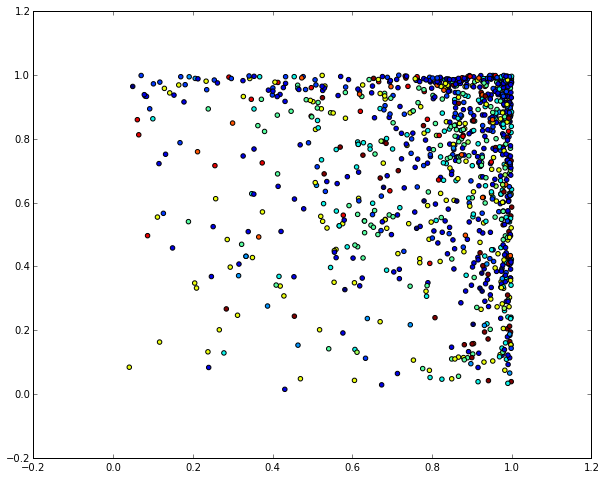

In [21]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# TODO: Set this at the top of the notebook
CUTOFF=1000

y_vals = np.array([y[0] for y in train_y[:CUTOFF]])
norm_y_vals = y_vals / float(np.amax(y_vals))

x1 = p[:CUTOFF,0]
x2 = p[:CUTOFF,1]

plt.scatter(x1, x2, c=norm_y_vals, s=20)
plt.show()

In [ ]:
# WORKING: how to visualize the filters in an autoencoder for text?
# Idea: pass the training data through and store the top N instances which activate this node
# at the end, output the top 5 instances for each node (convert window instance back to text)

# WORKING: visualize 2d autoencoder output

# WORKING: vizualize 2d stacked vs 2d "tied weights" autoencoders

# WORKING: Documents don't really give us any information about POS -- we need a better way of representing words
# idea: replicate most common 1000 words 4x
# encode each word with a 4000-dimensional vector indicating words which occur in POS-2, -1, +1, +2

# A stacked autoencoder can be used as part of an MLP, where the layers are "fine-tuned" for the task

# SIMPLIFICATION IDEA -- ONLY SELECT A SUBSET OF CLASSES (I.e. just noun vs. adj), THIS SHOULD MAKE COMPARISON EASIER

In [23]:
len(dataset_X.get_value()[1].nonzero()[0])
len(dataset_X.get_value()[1])
dataset_X.get_value().shape
[corpus_indices['idx2word'][w] for w in train_X[63624]]
corpus_indices['idx2tag'][train_y[63624][0]]

u'DET'

In [9]:
# In a separate notebook, compare 2d autoencoder vs 2d LSI -- visualize with scatter plots
# cite Hinton etc for this visualization methodology 

In [ ]:
# https://github.com/lisa-lab/DeepLearningTutorials

In [5]:
# def load_data(dataset):
#     ''' Loads the dataset

#     :type dataset: string
#     :param dataset: the path to the dataset (here MNIST)
#     '''

#     #############
#     # LOAD DATA #
#     #############

#     # Download the MNIST dataset if it is not present
#     data_dir, data_file = os.path.split(dataset)
# #     if data_dir == "" and not os.path.isfile(dataset):
# #         # Check if dataset is in the data directory.
# #         new_path = os.path.join(
# #             os.path.split(__file__)[0],
# #             "..",
# #             "data",
# #             dataset
# #         )
# #         if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
# #             dataset = new_path

#     if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
#         import urllib
#         origin = (
#             'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
#         )
#         print 'Downloading data from %s' % origin
#         urllib.urlretrieve(origin, dataset)

#     print '... loading data'

#     # Load the dataset
#     f = gzip.open(dataset, 'rb')
#     train_set, valid_set, test_set = cPickle.load(f)
#     f.close()
#     #train_set, valid_set, test_set format: tuple(input, target)
#     #input is an numpy.ndarray of 2 dimensions (a matrix)
#     #where rows correspond to an example. target is a
#     #numpy.ndarray of 1 dimensions (vector)) that have the same length as
#     #the number of rows in the input. It should give the target
#     #target to the example with the same index in the input.

#     def shared_dataset(data_xy, borrow=True):
#         """ Function that loads the dataset into shared variables

#         The reason we store our dataset in shared variables is to allow
#         Theano to copy it into the GPU memory (when code is run on GPU).
#         Since copying data into the GPU is slow, copying a minibatch everytime
#         is needed (the default behaviour if the data is not in a shared
#         variable) would lead to a large decrease in performance.
#         """
#         data_x, data_y = data_xy
#         shared_x = theano.shared(numpy.asarray(data_x,
#                                                dtype=theano.config.floatX),
#                                  borrow=borrow)
#         shared_y = theano.shared(numpy.asarray(data_y,
#                                                dtype=theano.config.floatX),
#                                  borrow=borrow)
#         # When storing data on the GPU it has to be stored as floats
#         # therefore we will store the labels as ``floatX`` as well
#         # (``shared_y`` does exactly that). But during our computations
#         # we need them as ints (we use labels as index, and if they are
#         # floats it doesn't make sense) therefore instead of returning
#         # ``shared_y`` we will have to cast it to int. This little hack
#         # lets us get around this issue
#         return shared_x, T.cast(shared_y, 'int32')

#     test_set_x, test_set_y = shared_dataset(test_set)
#     valid_set_x, valid_set_y = shared_dataset(valid_set)
#     train_set_x, train_set_y = shared_dataset(train_set)

#     rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
#             (test_set_x, test_set_y)]
#     return rval